# TASK IronITA  - Linguistica computazionale II
### Chiara Giurdanella 560686

In questo progetto è stato affrontato il seguente subtask A, di Irony detection:

- Classificazione a due classi (o binaria) in cui il sistema deve prevedere se un tweet è ironico o meno:

http://www.di.unito.it/~tutreeb/ironita-evalita18/index.html

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MaxAbsScaler
import re
import matplotlib.pyplot as plt

In [2]:
#lettura dataset
df= pd.read_csv('dataset_ironita_2018.csv', delimiter=",")

## Prima analisi

1. Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo basata solo su informazioni linguistiche non lessicali estratte utilizzando il sistema Profiling-UD. Riportare i seguenti risultati:

    - valutazione del sistema con un processo di 5-fold cross validation condotto sul training
    set;
    - valutazione del sistema sul test set ufficiale del task;
    - elenco delle 15 feature più importanti per la classificazione.

In [3]:
#verifica se la cartella 'txt_files' esiste
if not os.path.exists('txt_files'):
    # se non esiste la crea
    os.makedirs('txt_files')
#itera su ogni riga del dataframe    
for index, row in df.iterrows():
    #crea il nome del file utilizzando i valori delle colonne 'set', 'twitter_id' e 'irony'
    filename = str(row['set']) + '#' + str(row['twitter_id']) + '_' + str(row['irony']) + '.txt'   
    #definisce la cartella in cui il file sarà salvato
    folder = 'txt_files'    
    #crea il percorso completo del file utilizzando la cartella e il nome del file
    filepath = os.path.join(folder,filename)
    #apertura file in modalità scrittura
    with open(filepath, 'w',encoding='utf-8') as f:
        #scrive il testo della colonna 'text' nel file
        f.write(row['text'])

In [4]:
profiling_output_path = '6756.csv'

In [5]:
def load_dataset(src_path):
    #lista vuota per memorizzare il dataset
    dataset = []
    #itera su ogni riga del file di origine
    for line in open(src_path, 'r'):
        #dividela riga utilizzando il carattere di tabulazione '\t'
        splitted_line = line.strip().split('\t')
        #verifica se la riga corrisponde all'intestazione del file
        if splitted_line[0] == 'Filename':
            #estrae i nomi delle features dalla riga
            features_names = splitted_line[1:]
        else:
            #aggiunge la riga al dataset come elemento separato
            dataset.append(splitted_line)
    #restituisce il dataset e i nomi delle features estratte dall'intestazione
    return dataset, features_names

In [6]:
#la funzione load_dataset viene chiamata con l'argomento profiling_output_path
dataset, features_names = load_dataset(profiling_output_path)

In [7]:
print(f'Numero features: {len(features_names)}') #stampa il numero di caratteristiche nel dataset

Numero features: 133


## Divisione in train e test

In [8]:
def split_train_test(dataset):
    train_dataset = [] #lista vuota per memorizzare il training set
    test_dataset = [] #lista vuota per memorizzare il test set
    #itera su ogni riga/file nel dataset
    for file_line in dataset:
        #ottiene il nome del file dalla riga
        file_name = file_line[0]
        #verifica se il nome del file contiene la stringa 'training'
        if 'training' in file_name:
            #aggiunge la riga al training set
            train_dataset.append(file_line)
        else:
            # altrimenti la aggiunge al test set
            test_dataset.append(file_line)
    return train_dataset, test_dataset

In [9]:
train_dataset, test_dataset = split_train_test(dataset)
print('Tweet training set:', len(train_dataset)) #stampa il numero di tweet nel training set
print('Tweet test set:', len(test_dataset)) #stampa il numero di tweet nel test set

Tweet training set: 3977
Tweet test set: 872


## Creazione lista delle labels

In [10]:
def create_label_list(dataset):
    labels = []#lista vuota per memorizzare le etichette
    #per ogni riga/file nel dataset
    for file_line in dataset:
        #ottiene il nome del file
        file_name = file_line[0]
        #rimuove l'estensione ".conllu" dal nome del file
        file_name = file_name[0:-len('.conllu')]
        #effettua la suddivisione del nome del file utilizzando il carattere '_'
        splitted_file_name = file_name.split('_')
        #ottiene l'elemento in posizione 2 della suddivisione, che corrisponde alla classe irony
        irony = splitted_file_name[2]
        #aggiunge la classe alla lista precedentemente creata
        labels.append(irony)
    return labels

In [11]:
train_labels = create_label_list(train_dataset) #crea la lista di labels per il training set
test_labels = create_label_list(test_dataset) #crea la lista di labels per il test set

In [12]:
#rimozione del primo elemento (nome del file) per ogni documento di train e test set
for doc in train_dataset:
    doc.pop(0)

for doc in test_dataset:
    doc.pop(0)

## Normalizzazione

Prima di classificare dobbiamo normalizzare tutti i valori delle features tra 0 e 1. 
Per farlo utilizziamo il MinMaxScaler.

In [13]:
#creazione di un oggetto MinMaxScaler
scaler = MinMaxScaler()
#scala i dati nel training set utilizzando fit_transform
X_train = scaler.fit_transform(train_dataset)

## Classificazione

Addestriamo un Support Vector Classifier Lineare. Viene un oggetto LinearSVC con il parametro dual impostato su False, che indica l'uso di un algoritmo di ottimizzazione specifico per problemi di classificazione binaria. Successivamente il modello viene addestrato utilizzando il metodo fit con X_train come dati di addestramento e train_labels come etichette di addestramento.

In [14]:
svc = LinearSVC(dual=False)
svc.fit(X_train, train_labels)

LinearSVC(dual=False)

Il codice utilizza la funzione classification_report per valutare le previsioni del modello svc sui dati di addestramento. Questa funzione calcola e stampa un report di valutazione che include le metriche di precision, recall, f1-score e support per ogni classe.

## K-fold cross validation

Creazione dei 5 fold su cui verrà eseguita la classificazione

In [15]:
#converte la lista train_labels in un array NumPy
y_train = np.asarray(train_labels)
y_test = np.asarray(test_labels)

In [16]:
#creazione di un oggetto KFold, con k=5
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
#divisione dei dati in fold
folds = list(splitter.split(X_train))
for i in range(len(folds)): #per ciascun fold
    #stampa la lunghezza dei dati di training e dei dati di test
    print(len(folds[i][0]), len(folds[i][1]))

3181 796
3181 796
3182 795
3182 795
3182 795


In [17]:
all_y_true = [] #lista per memorizzare tutte le etichette di test reali
all_y_pred = [] #lista per memorizzare tutte le etichette predette
#per ciascun fold estraggo
for i in range(len(folds)):
    train_ids = folds[i][0] #indici dei dati di training per il fold corrente
    test_ids = folds[i][1] #indici dei dati di test per il fold corrente
    
    fold_X_train = X_train[train_ids] #dati di addestramento per il fold corrente
    fold_y_train = y_train[train_ids] #etichette di training per il fold corrente

    fold_X_test = X_train[test_ids] #dati di test per il fold corrente
    fold_y_test = y_train[test_ids] #etichette di test per il fold corrente
    
    #creazione di un nuovo modello LinearSVC per il fold corrente
    kfold_svc = LinearSVC(dual=False)
    kfold_svc.fit(fold_X_train, fold_y_train) #addestramento del modello sul fold corrente
    fold_y_pred = kfold_svc.predict(fold_X_test) #predizioni sul fold corrente
    fold_accuracy = accuracy_score(fold_y_test, fold_y_pred) #calcolo dell'accuracy sul fold corrente
   
    all_y_true += fold_y_test.tolist() #aggiunta delle etichette di test alla lista
    all_y_pred += fold_y_pred.tolist() #aggiunta delle predizioni alla lista
    print(f"Accuracy fold {i+1}: {fold_accuracy}") #stampa dell'accuratezza del fold corrente

Accuracy fold 1: 0.6482412060301508
Accuracy fold 2: 0.6469849246231156
Accuracy fold 3: 0.6666666666666666
Accuracy fold 4: 0.6477987421383647
Accuracy fold 5: 0.660377358490566


In [18]:
#valutazione del modello sulla base delle labels di test effettive e delle previsioni effettuate dal modello
print(classification_report(all_y_true, all_y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1954
           1       0.65      0.71      0.68      2023

    accuracy                           0.65      3977
   macro avg       0.66      0.65      0.65      3977
weighted avg       0.65      0.65      0.65      3977



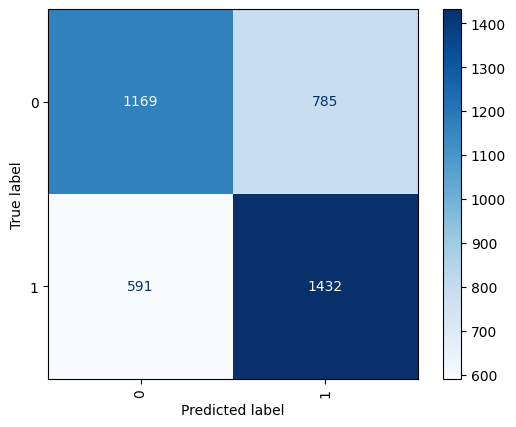

In [19]:
#visualizzazione della matrice di confusione
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, xticks_rotation='vertical', cmap='Blues');

## Test modello

Con il metodo transform, i dati di test vengono trasformati utilizzando le stesse medie e deviazioni standard calcolate sui dati di addestramento. In questo modo, i dati di test vengono resi coerenti con la scala applicata ai dati di addestramento.

In [20]:
#standardizzazione dei dati di test
X_test = scaler.transform(test_dataset)

In [21]:
#esegue le previsioni sulle caratteristiche di test
test_predictions = svc.predict(X_test)
#report di classificazione per la valutazione del modello
print(classification_report(test_labels, test_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.69      0.61      0.64       437
           1       0.65      0.72      0.68       435

    accuracy                           0.67       872
   macro avg       0.67      0.67      0.66       872
weighted avg       0.67      0.67      0.66       872



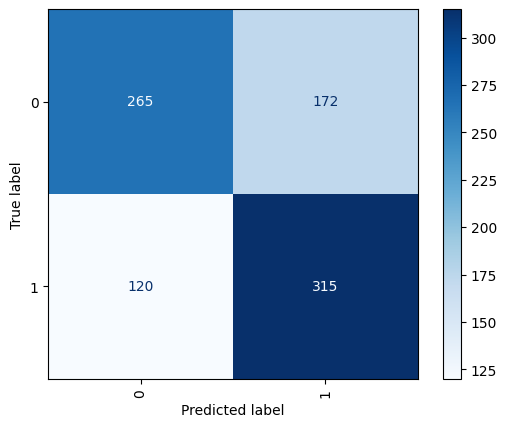

In [22]:
#visualizzazione della matrice di confusione
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues');

## Feature importance

L'attributo svc.coef_ restituisce i coefficienti appresi dal modello addestrato svc. La forma dell'array dei coefficienti dipende dal numero di classi nel problema di classificazione. Se il problema di classificazione ha solo due classi (n_classes = 2), allora l'array dei coefficienti avrà forma (1, n_features), dove n_features è il numero di caratteristiche utilizzate per l'addestramento del modello.

In [23]:
coefs = svc.coef_
coefs.shape

(1, 133)

Feature importance classe 0


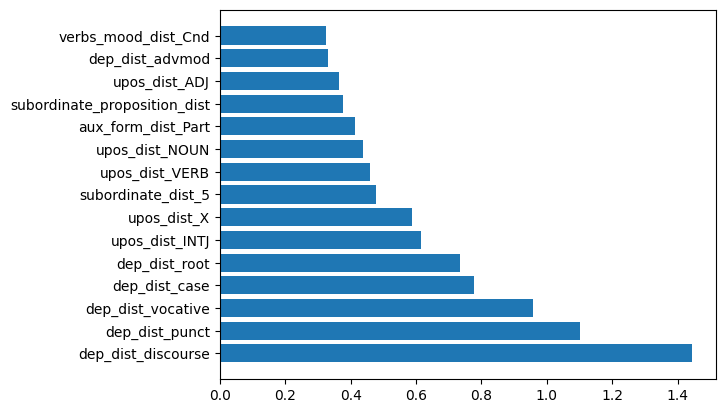

In [24]:
idx = 0
#seleziona i coefficienti per la classe specificata dall'indice idx
class_coefs = coefs[idx]
#creazione del dizionario delle feature importances
feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
#ordinamento delle feature importancesin ordine decrescente
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
#creazione di un barplot per mostrare le 15 feature più importanti per la classe 0
num_to_plot = 15
print(f'Feature importance classe {svc.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.show()

## Seconda analisi
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo basata su n-grammi di caratteri, parole e part-of-speech. Riportare i seguenti risultati:

   - testare diverse rappresentazioni del testo che variano rispetto alla lunghezza degli ngrammi utilizzati e/o rispetto al tipo di informazione utilizzata all’interno degli ngrammi (forme, lemmi, caratteri, part-of-speech) e valutare i diversi sistemi con un processo di 5-fold cross validation condotto sul training set.
    
   - valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il processo di 5-fold cross validation del punto sopra.

In [25]:
#percorso della directory in cui si trovano le annotazioni linguistiche dei file
conllu_dir = 'linguistic annotation of txtfiles'

In [26]:
train_files = []
test_files = []

for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    if 'training' in file_name:
        train_files.append(file_path)
    elif 'test' in file_name:
        test_files.append(file_path)

print('Documenti training set:', len(train_files))
print('Documenti test set:', len(test_files))

Documenti training set: 3977
Documenti test set: 872


In [27]:
def create_label_list(list_of_files):
    labels = []
    for file_path in list_of_files:
        #rimuove l'estensione del file
        file_path = file_path[:-len('.conllu')]
        #divide il percorso del file utilizzando il carattere di underscore
        splitted_file_path = file_path.split('_')
        #estrae l'etichetta di ironia dal percorso del file
        irony = splitted_file_path[1]
        #aggiunge l'etichetta alla lista delle etichette
        labels.append(irony)
    return labels

In [28]:
#stampa le prime 10 etichette di ironia per i file di addestramento
train_labels = create_label_list(train_files)
test_labels = create_label_list(test_files) #crea la lista di labels per il test set

In [29]:
def get_sentences_from_file(src_path):
    tweet_sentences = [] #lista che conterrà tutte le frasi di un tweet
    sentence = [] #lista usata per costruire una frase alla volta
    #iterazione sulle righe del file specificato da src_path
    for line in open(src_path, 'r'):
        if line[0].isdigit(): #se la riga inizia con un numero
            #divisione della riga in base al carattere di tabulazione
            splitted_line = line.strip().split('\t')
            if '-' not in splitted_line[0]: #se l'id della parola non contiene un trattino
                token = {
                    'word': splitted_line[1],
                    'lemma': splitted_line[2],
                    'pos': splitted_line[3]
                }
                sentence.append(token) #aggiunta del token alla lista sentence
        if line == '\n': #se la riga è vuota (la frase è finita)
            tweet_sentences.append(sentence) #aggiunta della frase alla lista tweet_sentences
            sentence = [] #reset della lista per costruire una nuova frase
    return tweet_sentences

In [30]:
#per ogni file nelle cartelle dei dataset invoca la funzione get_sentences_from_file e appende la lista restituita alla variabile dataset, restituendolo.
def get_dataset_from_files(file_paths):   
    #lista che conterrà la lista delle frasi in un file per ogni file del dataset
    dataset = []
    #per ogni file path nella lista dei file_paths 
    for file_path in file_paths:
        #invoca la funzione definita in precedenza
        sentences_infile = get_sentences_from_file(file_path)
        #appende sentences_infile restituito (quindi la lista delle frasi contenute in un singolo file)
        dataset.append(sentences_infile)        
    #restituisce una lista che contiene la lista delle frasi contenute nei file di un dataset
    return dataset

In [31]:
#invoco la funzione definita precedentemente sulle liste contenenti i percorsi dei file di train e test
train_dataset = get_dataset_from_files(train_files)
test_dataset = get_dataset_from_files(test_files)

#controllo se il numero di file corrispondono all'effettiva dimensione dei set
print('Documenti training set:', len(train_dataset))
print('Documenti test set:', len(test_dataset))

Documenti training set: 3977
Documenti test set: 872


In [32]:
#stampa le prime 5 frasi del primo elemento in train_dataset
train_dataset[0][:5]

[[{'word': 'Milano', 'lemma': 'Milano', 'pos': 'PROPN'},
  {'word': ',', 'lemma': ',', 'pos': 'PUNCT'},
  {'word': 'pullman', 'lemma': 'pullman', 'pos': 'NOUN'},
  {'word': 'sperona', 'lemma': 'sperono', 'pos': 'VERB'},
  {'word': 'tram', 'lemma': 'tram', 'pos': 'X'},
  {'word': ':', 'lemma': ':', 'pos': 'PUNCT'},
  {'word': 'immigrati', 'lemma': 'immigrato', 'pos': 'NOUN'},
  {'word': 'nordafricani', 'lemma': 'nordafricano', 'pos': 'ADJ'},
  {'word': 'sciacalli', 'lemma': 'sciacallo', 'pos': 'ADJ'},
  {'word': 'tra', 'lemma': 'tra', 'pos': 'ADP'},
  {'word': 'i', 'lemma': 'il', 'pos': 'DET'},
  {'word': 'feriti', 'lemma': 'ferito', 'pos': 'NOUN'},
  {'word': 'https://t.co/vBFCu0pzKM',
   'lemma': 'https://t.co/vBFCu0pzKM',
   'pos': 'PROPN'},
  {'word': 'https://t.co/XTRim7NQJZ',
   'lemma': 'https://t.co/XTRim7NQJZ',
   'pos': 'PROPN'}]]

### Estrazione features

In [33]:
sentence = train_dataset[10][0]
sentence

[{'word': 'L’', 'lemma': 'il', 'pos': 'DET'},
 {'word': 'accordo', 'lemma': 'accordo', 'pos': 'NOUN'},
 {'word': 'fra', 'lemma': 'fra', 'pos': 'ADP'},
 {'word': 'Italia', 'lemma': 'Italia', 'pos': 'PROPN'},
 {'word': 'e', 'lemma': 'e', 'pos': 'CCONJ'},
 {'word': 'Libia', 'lemma': 'Libia', 'pos': 'PROPN'},
 {'word': 'su', 'lemma': 'su', 'pos': 'ADP'},
 {'word': 'i', 'lemma': 'il', 'pos': 'DET'},
 {'word': 'migranti', 'lemma': 'migrante', 'pos': 'NOUN'},
 {'word': 'https://t.co/yfJBXqbpWP',
  'lemma': 'https://t.co/yfJBXqbpWP',
  'pos': 'PROPN'}]

In [34]:
def extract_word_ngrams(word_ngrams, sentence, el, n):
    #creiamo una lista con tutte le parole
    all_words = []
    #per ciascun token nella lista sentence
    for token in sentence:
        #aggiungiamo la parola corrispondente all'elemento specificato (el) alla lista all_words
        all_words.append(token[el])   
    #scorriamo la lista delle parole e estraiamo gli n-grammi
    for i in range(0, len(all_words) - n + 1):
        ngram_words = all_words[i: i + n]
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        #se l'n-gramma non è presente nel dizionario word_ngrams
        if ngram not in word_ngrams:
            #lo aggiungiamo al dizionario con conteggio 1
            word_ngrams[ngram] = 1
        else:
            #altrimenti incrementiamo il conteggio
            word_ngrams[ngram] += 1  
    return word_ngrams

In [35]:
#estrae gli n-grammi di parole dalla frase
#utilizzando come elemento le parole stesse e considerando n-grammi di lunghezza 3
extract_word_ngrams(dict(), sentence, 'word', 3)

{'WORD_3_L’_accordo_fra': 1,
 'WORD_3_accordo_fra_Italia': 1,
 'WORD_3_fra_Italia_e': 1,
 'WORD_3_Italia_e_Libia': 1,
 'WORD_3_e_Libia_su': 1,
 'WORD_3_Libia_su_i': 1,
 'WORD_3_su_i_migranti': 1,
 'WORD_3_i_migranti_https://t.co/yfJBXqbpWP': 1}

In [36]:
def extract_char_ngrams(char_ngrams, sentence, n):   
    #creiamo una lista con tutte le parole
    all_words = []
    for token in sentence:
        all_words.append(token['word']) #estrae la parola da ogni token
    #crea una stringa che contenga tutte le parole separate da spazi (per scorrere i caratteri)
    all_words = ' '.join(all_words)   
    #scorriamo la stringa ed estraiamo gli n-grammi di caratteri
    for i in range(0, len(all_words) - n + 1):
        ngram_chars = all_words[i:i + n]
        ngram = f'CHAR_{n}_' + ngram_chars
        # print(f'{i}: {ngram_chars} -> {ngram}')
        #se l'n-gramma non è presente nel dizionario char_ngrams
        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1 #lo aggiungiamo al dizionario con conteggio 1
        else:
            char_ngrams[ngram] += 1 #altrimenti incrementiamo il conteggio    
    return char_ngrams

In [37]:
#calcola gli n-grammi di caratteri dalle parole nella frase
#restituisce un dizionario contenente il conteggio di ciascun n-gramma
extract_char_ngrams(dict(), sentence, 2);

In [38]:
def count_document_words(document):
    num_words = 0 #variabile per memorizzare il numero totale di parole
    for sentence in document: #itera le frasi nel documento
        #aggiunge il numero di parole nella frase corrente al conteggio totale
        num_words = num_words + len(sentence)
    return num_words #restituisce il numero totale di parole nel documento

def count_document_chars(document):
    num_chars = 0 #variabile per memorizzare il numero totale di caratteri
    for sentence in document: #itera le frasi nel documento
        for token in sentence: #itera i tokens nella frase corrente
            #aggiunge la lunghezza della parola corrente al conteggio totale dei caratteri
            num_chars = num_chars + len(token['word'])
        #aggiunge la lunghezza della frase corrente al conteggio totale dei caratteri
        num_chars = num_chars + len(sentence) - 1  #contiamo anche gli spazi
    return num_chars #restituisce il numero totale di caratteri nel documento

def normalize_ngrams(ngrams_dict, doc_len):
    for ngram in ngrams_dict: #itera gli n-grammi nel dizionario
        #normalizza il conteggio dell'n-gramma dividendo per la lunghezza del documento
        ngrams_dict[ngram] = ngrams_dict[ngram]/float(doc_len)

In [39]:
#Estrazione features degli n-grammi di parole e caratteri da un dataset di documenti
def extract_features_1(dataset):
    dataset_features = [] #lista per memorizzare le features di ciascun documento nel dataset
    
    #per ogni tweet nel dataset crea 4 dizionari
    for document in dataset:
        word_unigrams = dict() #dizionario per memorizzare i conteggi degli unigrammi di parole
        word_bigrams = dict() #dizionario per memorizzare i conteggi dei bigrammi di parole
        char_unigrams = dict() #dizionario per memorizzare i conteggi degli unigrammi di caratteri
        char_bigrams = dict() #dizionario per memorizzare i conteggi dei bigrammi di caratteri
        
        #per ciascuna frase in un tweet
        for sentence in document:
            #estrae gli unigrammi di parole dalla frase e aggiorna il dizionario word_unigrams
            extract_word_ngrams(word_unigrams, sentence, 'word', 1)
            #estrae i bigrammi di parole dalla frase e aggiorna il dizionario word_bigrams
            extract_word_ngrams(word_bigrams, sentence, 'word', 2)
            #estrae gli unigrammi di caratteri dalla frase e aggiorna il dizionario char_unigrams
            extract_char_ngrams(char_unigrams, sentence, 1)
            #estrae i bigrammi di caratteri dalla frase e aggiorna il dizionario char_bigrams
            extract_char_ngrams(char_bigrams, sentence, 2)
            
            #conta il numero di caratteri e parole per ogni tweet
            num_words = count_document_words(document)
            num_chars = count_document_chars(document)
        
            #normalizza gli ngrammi estratti in precedenza con il numero totale di caratteri e parole a seconda del caso
            normalize_ngrams(word_unigrams, num_words)
            normalize_ngrams(word_bigrams, num_words)
            normalize_ngrams(char_unigrams, num_chars)
            normalize_ngrams(char_bigrams, num_chars)
        
        #unisce tutti i dizionari di n-grammi per ottenere le features del tweet
        tweet_features = word_unigrams | word_bigrams | char_unigrams | char_bigrams
        
        #crea un dizionario di features per il tweet corrente, unendo tutti gli n-grammi
        tweet_features = dict()
        for ngrams_dict in [word_unigrams, word_bigrams, char_unigrams, char_bigrams]:
            for ngram in ngrams_dict:
                tweet_features[ngram] = ngrams_dict[ngram]
        
        #aggiunge le features del tweet alla lista delle features del dataset
        dataset_features.append(tweet_features)
    return dataset_features

In [40]:
def extract_features_2(dataset):
    
    dataset_features = []
    #per ogni tweet del dataset crea 6 nuovi dizionari
    for document in dataset:
        word_trigrams = dict()
        word_bigrams = dict()
        char_trigrams = dict()
        char_bigrams = dict()
        pos_bigrams = dict()
        pos_trigrams = dict()
        
        #per ogni frase in un tweet vengono popolati i dizionari 
        for sentence in document: 
            extract_word_ngrams(word_bigrams, sentence, 'word', 2)
            extract_word_ngrams(word_trigrams, sentence, 'word', 3)
            extract_char_ngrams(char_bigrams, sentence, 2)
            extract_char_ngrams(char_trigrams, sentence, 3)
            extract_word_ngrams(pos_bigrams, sentence, 'pos', 2)
            extract_word_ngrams(pos_bigrams, sentence, 'pos', 3)
            
            #conta il numero di caratteri e parole per ogni tweet
            num_words = count_document_words(document)
            num_chars = count_document_chars(document)
            
            #normalizzazione degli n-grammi estratti in precedenza
            normalize_ngrams(word_trigrams, num_words)
            normalize_ngrams(word_bigrams, num_words)
            normalize_ngrams(char_trigrams, num_chars)
            normalize_ngrams(char_bigrams, num_chars)
            normalize_ngrams(pos_bigrams, num_words)
            normalize_ngrams(pos_trigrams, num_words)         
        
        #unisce tutti i dizionari di n-grammi per ottenere le features del tweet
        tweet_features = dict()
        for ngrams_dict in [word_trigrams, word_bigrams, char_trigrams, char_bigrams, pos_bigrams, pos_trigrams]:
            for ngram in ngrams_dict:
                tweet_features[ngram] = ngrams_dict[ngram]

        dataset_features.append(tweet_features)
    return dataset_features

In [41]:
def extract_features_3(dataset):
    
    dataset_features = []
    for document in dataset:
        word_unigrams = dict()
        word_bigrams = dict()
        pos_bigrams = dict()
        pos_unigrams = dict()
         
        for sentence in document:
            extract_word_ngrams(word_bigrams, sentence, 'word', 2)
            extract_word_ngrams(word_unigrams, sentence, 'word', 1)
            extract_word_ngrams(pos_bigrams, sentence, 'pos', 2)
            extract_word_ngrams(pos_unigrams, sentence, 'pos', 1)
      
            num_words = count_document_words(document)
            
            normalize_ngrams(word_bigrams, num_words)
            normalize_ngrams(word_unigrams, num_words)
            normalize_ngrams(pos_bigrams, num_words)
            normalize_ngrams(pos_unigrams, num_words)
        
        tweet_features = dict()
        for ngrams_dict in [word_bigrams, word_unigrams, pos_bigrams, pos_unigrams]:
            for ngram in ngrams_dict:
                tweet_features[ngram] = ngrams_dict[ngram]

        dataset_features.append(tweet_features)
    return dataset_features

In [42]:
#estrazione delle features dal training set
#train_features conterrà la lista delle features estratte per ciascun documento nel training set
train_features_1 = extract_features_1(train_dataset)
test_features_1 = extract_features_1(test_dataset)

train_features_2 = extract_features_2(train_dataset)
test_features_2 = extract_features_2(test_dataset)

train_features_3 = extract_features_3(train_dataset)
test_features_3 = extract_features_3(test_dataset)

In [43]:
print('Documenti training set:', len(train_features_1),",", len(train_features_2),",", len(train_features_3))
print('Documenti test set:', len(test_features_1),",", len(test_features_2),",", len(test_features_3))

Documenti training set: 3977 , 3977 , 3977
Documenti test set: 872 , 872 , 872


In [44]:
def get_num_features(dataset):
    #insieme vuoto che contenerrà tutte le features uniche
    all_features = set()
    #scorriamo ogni dizionario di features nel dataset
    for tweet_dict in dataset:
        #aggiungiamo tutte le chiavi (features) al nostro insieme
        all_features.update(list(tweet_dict.keys()))
    #la lunghezza dell'insieme rappresenta il numero di features uniche nel dataset
    return len(all_features)

In [45]:
#numero di features presenti nel dataset di addestramento 
print(f'Numero features caso 1: {get_num_features(train_features_1)}')
print(f'Numero features caso 1: {get_num_features(test_features_1)}')

print(f'Numero features caso 2: {get_num_features(train_features_2)}')
print(f'Numero features caso 2: {get_num_features(test_features_2)}')

print(f'Numero features caso 3: {get_num_features(train_features_3)}')
print(f'Numero features caso 3: {get_num_features(test_features_3)}')

Numero features caso 1: 69601
Numero features caso 1: 21428
Numero features caso 2: 139929
Numero features caso 2: 41822
Numero features caso 3: 64656
Numero features caso 3: 18117


### Filtro delle features poco frequenti

In [46]:
def filter_features(train_features, min_occurrences):
    #dizionario per contare quante volte una feature compare in diversi tweet
    features_counter = dict()
    #per ogni dizionario di features in train_features
    for tweet_dict in train_features:
        #per ogni feature nel dizionario
        for feature in tweet_dict:
            if feature in features_counter: #se la feature è già presente nel dizionario features_counter
                features_counter[feature] += 1 #incrementiamo il contatore di quella featur di 1
            else: #se non è presente
                features_counter[feature] = 1 #aggiungiamo la feature al dizionario con valore 1
    
    #per ogni dizionario di features in train_features
    for tweet_dict in train_features:
        #creiamo la lista di features del tweet corrente
        tweet_features = list(tweet_dict.keys())
        #per ogni feature nella lista tweet_features
        for feature in tweet_features:
            #se il contatore delle sue occorrenze è inferiore a min_occurrences
            if features_counter[feature] < min_occurrences:
                #la feature viene rimossa dal dizionario
                tweet_dict.pop(feature)  
    #restituisce il train_features con le features filtrate
    return train_features

In [47]:
#rimozione delle features che compaiono in meno di tot tweet
#stampa del numero di features presenti nel dataset di addestramento dopo il filtro
train_features_1 = filter_features(train_features_1, 5)
print(f'Numero features del train set (Caso 1): {get_num_features(train_features_1)}')

test_features_1 = filter_features(test_features_1, 5)
print(f'Numero features del test set (Caso 1): {get_num_features(test_features_1)}')

train_features_2 = filter_features(train_features_2, 5)
print(f'Numero features del train set (Caso 2): {get_num_features(train_features_2)}')

test_features_2 = filter_features(test_features_2, 5)
print(f'Numero features del test set (Caso 2): {get_num_features(test_features_2)}')

train_features_3 = filter_features(train_features_3, 5)
print(f'Numero features del train set (Caso 3): {get_num_features(train_features_3)}')

test_features_3 = filter_features(test_features_3, 5)
print(f'Numero features del test set (Caso 3): {get_num_features(test_features_3)}')

Numero features del train set (Caso 1): 5233
Numero features del test set (Caso 1): 1440
Numero features del train set (Caso 2): 10290
Numero features del test set (Caso 2): 4093
Numero features del train set (Caso 3): 3062
Numero features del test set (Caso 3): 649


### Classificazione

In [48]:
#converte la lista train_labels in un array NumPy
y_train = np.asarray(train_labels)
y_test = np.asarray(test_labels)

In [49]:
def k5fold_classification(train_features, test_features, y_train, y_test, invocation1):
    
    print(f" \n Feature estratte a partire da {invocation1}. \n")
    
    #converto un elenco di dizionari in una rappresentazione vettoriale numerica tramite DictVectorizer
    vectorizer = DictVectorizer()
    #trasformare le features di addestramento in una rappresentazione vettoriale
    X_train = vectorizer.fit_transform(train_features)
    X_test = vectorizer.transform(test_features)

    #normalizziamo ogni feature dividendo per il valore massimo assoluto presente in quella feature
    scaler = MaxAbsScaler()
    #trasformare le features di addestramento utilizzando lo scaler MaxAbs
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #estraiamo le feature tramite il metodo specifico del vectorizer
    features_names = vectorizer.get_feature_names_out(X_train).tolist()
    #salvo in un numpy array le classi del train set
    y_train = np.asarray(y_train)

    #definisco lo splitter con 5 split, una mescolanza dei dati pre split e con seed 42
    splitter = KFold(n_splits=5, random_state=42, shuffle=True)
    #effettuo lo split e salvo gli split in folds
    folds = list(splitter.split(X_train))

    #visualizzo tramite ciclo il numero di istanze di train e validation per ogni fold
    for i in range(len(folds)):
        print("Fold ",(i+1), len(folds[i][0]),",", len(folds[i][1]))
        

    print("\n")
    #lista per memorizzare le predizioni e le classi reali su tutti i fold
    all_y_true = []
    all_y_pred = []

    #per ciascun fold
    for i in range(len(folds)):

        #estraggo gli indici di train e validation (qui e di seguito definito test) per il fold corrente
        train_ids = folds[i][0]
        test_ids = folds[i][1]

        #suddivido i dati in train e validation per il fold corrente tramite la localizzazione degli ID estratti in folds
        fold_X_train = X_train[train_ids]
        fold_y_train = y_train[train_ids]

        fold_X_test = X_train[test_ids]
        fold_y_test = y_train[test_ids]

        #creo un classificatore LinearSVC
        kfold_svc = LinearSVC(dual=False)
        #addestro il classificatore sul set di train del fold corrente
        kfold_svc.fit(fold_X_train, fold_y_train)
        #eseguo le previsioni sul set di validation del fold corrente
        fold_y_pred = kfold_svc.predict(fold_X_test)
        #calcolo l'accuratezza del modello sul fold corrente
        fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)

        #stampo l'accuratezza del fold corrente
        print(f"Accuracy su fold {i+1}: {fold_accuracy}")

        #aggiungo le previsioni e i valori reali delle classi del fold corrente alle liste complessive
        all_y_true += fold_y_test.tolist()
        all_y_pred += fold_y_pred.tolist()

      
    #Valutazione sul training set completo tramite classification report
    print(" \n Valutazione sul training set: \n")
    print("\n",classification_report(all_y_true, all_y_pred, zero_division=0))

    #Valutazione sul test set completo tramite classification report
    print(" \n Valutazione sul test set: \n")
    test_predictions = kfold_svc.predict(X_test)
    print("\n", classification_report(y_test, test_predictions, zero_division=0))

    #Matrice di confusione sul test set
    cm_test = confusion_matrix(y_test, test_predictions)
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title(f"Matrice di Confusione - Test Set")
    plt.show()

    print("--------------------------------------------------------------------------------------------------------------------")

 
 Feature estratte a partire da unigrammi e bigrammi di caratteri e parole. 

Fold  1 3181 , 796
Fold  2 3181 , 796
Fold  3 3182 , 795
Fold  4 3182 , 795
Fold  5 3182 , 795


Accuracy su fold 1: 0.6419597989949749
Accuracy su fold 2: 0.6520100502512562
Accuracy su fold 3: 0.6591194968553459
Accuracy su fold 4: 0.6616352201257861
Accuracy su fold 5: 0.6792452830188679
 
 Valutazione sul training set: 


               precision    recall  f1-score   support

           0       0.66      0.64      0.65      1954
           1       0.66      0.68      0.67      2023

    accuracy                           0.66      3977
   macro avg       0.66      0.66      0.66      3977
weighted avg       0.66      0.66      0.66      3977

 
 Valutazione sul test set: 


               precision    recall  f1-score   support

           0       0.68      0.62      0.65       437
           1       0.65      0.71      0.68       435

    accuracy                           0.66       872
   macro avg  

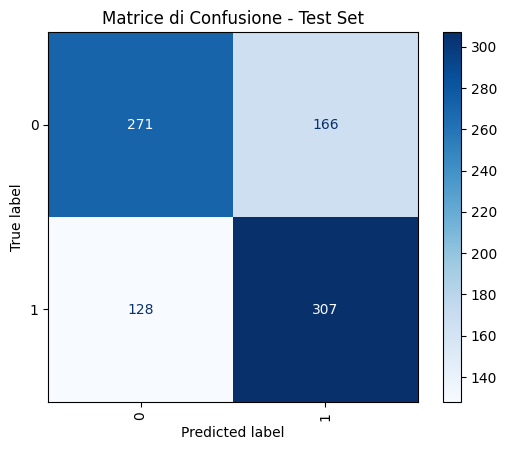

--------------------------------------------------------------------------------------------------------------------
 
 Feature estratte a partire da bigrammi e trigrammi di caratteri e parole. 

Fold  1 3181 , 796
Fold  2 3181 , 796
Fold  3 3182 , 795
Fold  4 3182 , 795
Fold  5 3182 , 795


Accuracy su fold 1: 0.6595477386934674
Accuracy su fold 2: 0.6582914572864321
Accuracy su fold 3: 0.6616352201257861
Accuracy su fold 4: 0.6716981132075471
Accuracy su fold 5: 0.6767295597484276
 
 Valutazione sul training set: 


               precision    recall  f1-score   support

           0       0.66      0.64      0.65      1954
           1       0.67      0.69      0.68      2023

    accuracy                           0.67      3977
   macro avg       0.67      0.67      0.67      3977
weighted avg       0.67      0.67      0.67      3977

 
 Valutazione sul test set: 


               precision    recall  f1-score   support

           0       0.64      0.60      0.62       437
      

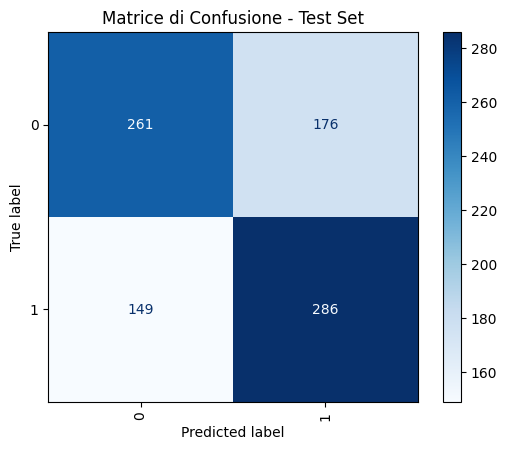

--------------------------------------------------------------------------------------------------------------------
 
 Feature estratte a partire da unigrammi e trigrammi di part of speech e parole. 

Fold  1 3181 , 796
Fold  2 3181 , 796
Fold  3 3182 , 795
Fold  4 3182 , 795
Fold  5 3182 , 795


Accuracy su fold 1: 0.635678391959799
Accuracy su fold 2: 0.6695979899497487
Accuracy su fold 3: 0.6490566037735849
Accuracy su fold 4: 0.6767295597484276
Accuracy su fold 5: 0.6742138364779874
 
 Valutazione sul training set: 


               precision    recall  f1-score   support

           0       0.67      0.61      0.64      1954
           1       0.65      0.71      0.68      2023

    accuracy                           0.66      3977
   macro avg       0.66      0.66      0.66      3977
weighted avg       0.66      0.66      0.66      3977

 
 Valutazione sul test set: 


               precision    recall  f1-score   support

           0       0.68      0.55      0.61       437
 

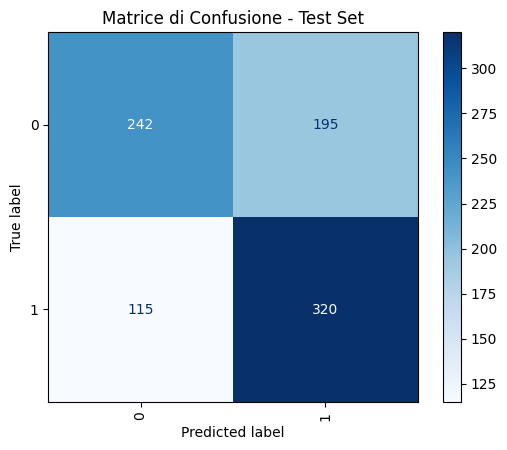

--------------------------------------------------------------------------------------------------------------------


In [50]:
invocation_1 = "unigrammi e bigrammi di caratteri e parole";
invocation_2 = "bigrammi e trigrammi di caratteri e parole";
invocation_3 = "unigrammi e trigrammi di part of speech e parole";

# Classificazione sul dataset le cui feature consistono in bigrammi e unigrammi di caratteri e parole 
k5fold_classification(train_features_1, test_features_1, y_train, y_test, invocation_1)
# Classificazione sul dataset le cui feature consistono in bigrammi e trigrammi di caratteri e parole 
k5fold_classification(train_features_2, test_features_2, y_train, y_test, invocation_2) 
# Classificazione sul dataset le cui feature consistono in unigrammi e bigrammi di pos e parole 
k5fold_classification(train_features_3, test_features_3, y_train, y_test, invocation_3) 

## Terza analisi
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo costruita attraverso l’uso dei word embedding (http://www.italianlp.it/resources/italian-word-embeddings/). Riportare i seguenti risultati:
- testare diverse rappresentazioni del testo che variano rispetto al modo di combinare gli embedding delle singole parole e/o rispetto alle categorie grammaticali delle parole prese in considerazione. Valutare i diversi sistemi con un processo di 5-fold cross validation condotto sul training set.
- valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il processo di 5-fold cross validation del punto sopra .

### Caricamento embeddings

In [51]:
#impostiamo le dimensioni degli embeddings a 32
embeddings_dim = 32
#generiamo il percorso del file degli embeddings utilizzando le dimensioni degli embeddings
embeddings_path = f'twitter{embeddings_dim}.txt'

In [52]:
def load_word_embeddings(src_path):
    embeddings = dict()
    #ogni riga nel file
    for line in open(embeddings_path, 'r'):
        #viene suddivisa utilizzando il delimitatore "\t" per ottenere la parola e le componenti dell'embedding
        line = line.strip().split('\t')
        #la parola viene assegnata alla variabile word
        word = line[0]
        embedding = line[1:]
        #convertiamo le componenti dell'embedding in float
        embedding = [float(comp) for comp in embedding]
        #trasformiamo la lista delle componenti in un vettore di numpy
        embeddings[word] = np.asarray(embedding)
    return embeddings

In [53]:
#embeddings conterrà il dizionario degli embeddings delle parole caricati dal file
embeddings = load_word_embeddings(embeddings_path)

## Caricamento dataset

In [54]:
#percorso della directory in cui si trovano le annotazioni linguistiche dei file
conllu_dir = 'linguistic annotation of txtfiles'

In [55]:
train_files = []
test_files = []

for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    if 'training' in file_name:
        train_files.append(file_path)
    elif 'test' in file_name:
        test_files.append(file_path)

print('Documenti training set:', len(train_files))
print('Documenti test set:', len(test_files))

Documenti training set: 3977
Documenti test set: 872


## Normalizzazione

In [56]:
def get_digits(text):
    try:
        val = int(text) #converte il testo in un intero
    except: #se la conversione fallisce
        text = re.sub('\d', '@Dg', text) #sostituiamo tutte le cifre con "@Dg"
        return text
    if val >= 0 and val < 2100: #se il valore è compreso tra 0 e 2099
        return str(val) #restituiamo il numero come stringa
    else:
        return "DIGLEN_" + str(len(str(val)))

In [57]:
def normalize_text(word):
     #se il testo contiene "http" o un punto e una barra (possibile URL)
    if "http" in word or ("." in word and "/" in word):
        word = str("___URL___") #sostituiamo la parola con "URL"
        return word
    #se la lunghezza della parola è maggiore di 26 caratteri
    if len(word) > 26:
        return "__LONG-LONG__" #restituiamo una stringa che indica una parola molto lunga
    #otteniamo una versione normalizzata del testo numerico
    new_word = get_digits(word)
    if new_word != word: #se il testo numerico è diverso dal testo originale
        word = new_word #aggiorniamo la parola con il testo numerico normalizzato
    if word[0].isupper(): #se il primo carattere della parola è maiuscolo
        word = word.capitalize() #trasformiamo la parola con iniziale maiuscola
    else:
        word = word.lower() #trasformiamo la parola in minuscolo
    return word

In [58]:
def get_tokens_from_file(src_path):
    tweet_tokens = [] #lista per memorizzare i token dell'utente
    lines_to_skip = 0 #numero di righe da saltare dopo un token con indice composto
    take_pos = False #indica che la prossima riga contiene la parte del discorso
    for line in open(src_path, 'r'): #iteriamo su ciascuna riga del file
        # print(f'\nRiga: {line.strip()}')
        if line[0].isdigit(): #se il primo carattere della riga è un numero
            splitted_line = line.strip().split('\t') #dividiamo la riga in base al carattere di tab
            if '-' in splitted_line[0]: #se l'indice del token è composto
                skip_ids = splitted_line[0].split('-') #otteniamo gli indici da saltare
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 #calcoliamo il numero di righe da saltare
                take_pos = True #booleano che indica che dobbiamo prendere la pos della prossima parola
                word = normalize_text(splitted_line[1]) #normalizziamo il testo del token
                pos = splitted_line[3] #otteniamo la parte del discorso
                token = {
                    'word': word,
                    'pos': pos
                }
                tweet_tokens.append(token) #aggiungiamo il token alla lista dei token del tweet
            else: #se l'indice del token non è composto
                if lines_to_skip == 0: #se non ci sono righe da saltare    
                    word = normalize_text(splitted_line[1]) #normalizziamo il testo del token
                    pos = splitted_line[3] #otteniamo la parte del discorso
                    token = {
                        'word': word,
                        'pos': pos
                    }
                    tweet_tokens.append(token) #aggiungiamo il token alla lista dei token del tweet
                if take_pos:
                    pos = splitted_line[3]
                    tweet_tokens[-1]['pos'] = pos #aggiorniamo la parte del discorso del token precedente
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip-1) #riduciamo il numero di righe da saltare 
    return tweet_tokens

In [59]:
#liste per memorizzare i dataset di train e test
train_dataset = []
test_dataset = []

def create_df(df_of_paths, final_df):
    
    #itera sui percorsi dei tweet nel dataset
    for tweet_path in df_of_paths:
        #ottiene i token dal file del tweet
        tweet_sentences = get_tokens_from_file(tweet_path)
        #aggiunge i token alla lista finale dei dataset
        final_df.append(tweet_sentences)

#crea il dataset di train e test
create_df(train_files, train_dataset)
create_df(test_files, test_dataset)

In [60]:
#controllo se il numero di file corrispondono all'effettiva dimensione dei set
print('Documenti training set:', len(train_dataset))
print('Documenti test set:', len(test_dataset))

Documenti training set: 3977
Documenti test set: 872


In [61]:
print("\"Tokens\" presenti nel primo tweet del train set: \n", train_dataset[0])

"Tokens" presenti nel primo tweet del train set: 
 [{'word': 'Milano', 'pos': 'PROPN'}, {'word': ',', 'pos': 'PUNCT'}, {'word': 'pullman', 'pos': 'NOUN'}, {'word': 'sperona', 'pos': 'VERB'}, {'word': 'tram', 'pos': 'X'}, {'word': ':', 'pos': 'PUNCT'}, {'word': 'immigrati', 'pos': 'NOUN'}, {'word': 'nordafricani', 'pos': 'ADJ'}, {'word': 'sciacalli', 'pos': 'ADJ'}, {'word': 'tra', 'pos': 'ADP'}, {'word': 'i', 'pos': 'DET'}, {'word': 'feriti', 'pos': 'NOUN'}, {'word': '___URL___', 'pos': 'PROPN'}, {'word': '___URL___', 'pos': 'PROPN'}]


## Estrazione features

Questa funzione calcola la media degli embeddings di un tweet. Prende in input una matrice di embeddings tweet_embeddings, dove ogni riga rappresenta un embedding di un token nel tweet. La funzione esegue la somma degli embeddings lungo l'asse 0, cioè somma gli embeddings elemento per elemento. Successivamente, calcola la media dividendo la somma per il numero di embeddings nel vettore.

In [62]:
#calcola la media degli embedding dei tweet
def compute_embeddings_mean(tweet_embeddings):
    #somma gli embedding dei tweet
    sum_array = np.sum(tweet_embeddings, axis=0)
    #divide la somma per il numero di embedding dei tweet per ottenere la media
    mean_array = np.divide(sum_array, len(tweet_embeddings))
    return mean_array

### Combinazione 1: media di tutti gli embeddings dei tweet 

In [63]:
#Funzione che calcola la media di tutti i word embeddings di un tweet
def compute_all_embeddings_mean(tweet_tokens):
    #lista che conterrà gli embeddings dei token del tweet
    tweet_embeddings = []
    #per ciascun token del tweet
    for token in tweet_tokens:
        #estrae la parola
        word = token['word']
        #se questa è presente (ha un embedding associato)
        if word in embeddings:
            #recupera il corrispondente embedding  e lo aggiunge alla lista
            tweet_embeddings.append(embeddings[word])
    #se la lista è vuota significa che nessuna delle parole del tweet ha un embedding associato
    if len(tweet_embeddings) == 0:
        #quindi viene creato un embedding di dimensione embeddings_dim contenente solo zeri
        tweet_embeddings = [np.zeros(embeddings_dim)]
    #calcola la media degli embeddings nella lista 
    tweet_embeddings = compute_embeddings_mean(tweet_embeddings)
    return tweet_embeddings

### Combinazione 2: media degli embeddings dei tweet di aggettivi, nomi e verbi

In [64]:
#Funzione che calcola la media dei word embeddings solo di aggettivi, nomi e verbi
def compute_filtered_embeddings_mean(tweet_tokens):
    tweet_embeddings = [] #lista per memorizzare gli embeddings dei token selezionati
    #per ciascun token del tweet
    for token in tweet_tokens:
        #vengono estratte la parola e la parte del discorso
        word = token['word']
        pos = token['pos']
        #se la parola è presente negli embeddings e se la parte del discorso è ADJ, NOUN o VERB
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB']:
            #recupera il corrispondente embedding  e lo aggiunge alla lista
            tweet_embeddings.append(embeddings[word])
    if len(tweet_embeddings) == 0: #se la lista è vuota
        tweet_embeddings = [np.zeros(embeddings_dim)] #viene inserito un array di zeri
    #calcola la media degli embeddings nella lista
    tweet_embeddings = compute_embeddings_mean(tweet_embeddings)
    return tweet_embeddings

### Combinazione 3: media degli embeddings di aggettivi, sostantivi e verbi, calcolata separatamente

In [65]:
#Funzione che calcola la media separatamente dei word embedding di aggettivi, nomi e verbi, e concatena i 3 vettori ottenuti
def compute_filtered_embeddings_sep_means(tweet_tokens):
    #vengono inizializzate tre liste vuote per contenere gli embeddings di aggettivi, nomi e verbi
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    #per ciascun token del tweet
    for token in tweet_tokens:
        #vengono estratte la parola e la parte del discorso
        word = token['word']
        pos = token['pos']
        #se la parola è presente negli embeddings e se la parte del discorso è ADJ
        if word in embeddings and pos in ['ADJ']:
            #l'embedding corrispondente viene aggiunto alla lista adj_embeddings
            adj_embeddings.append(embeddings[word])
        #se la parola è presente negli embeddings e se la parte del discorso è NOUN
        elif word in embeddings and pos in ['NOUN']:
            #l'embedding corrispondente viene aggiunto alla lista noun_embeddings
            noun_embeddings.append(embeddings[word])
        #se la parola è presente negli embeddings e se la parte del discorso è VERB
        elif word in embeddings and pos in ['VERB']:
            #l'embedding corrispondente viene aggiunto alla lista verb_embeddings
            verb_embeddings.append(embeddings[word])
    #se le liste sono vuote viene inserito un array di zeri 
    if len(adj_embeddings) == 0:
        adj_embeddings = [np.zeros(embeddings_dim)]
    if len(noun_embeddings) == 0:
        noun_embeddings = [np.zeros(embeddings_dim)]
    if len(verb_embeddings) == 0:
        verb_embeddings = [np.zeros(embeddings_dim)]
    #vengono calcolate le medie degli embeddings di ciascuna lista
    adj_embeddings = compute_embeddings_mean(adj_embeddings)
    noun_embeddings = compute_embeddings_mean(noun_embeddings)
    verb_embeddings = compute_embeddings_mean(verb_embeddings)
    #gli embeddings risultanti vengono concatenati in un singolo array 
    tweet_embeddings = np.concatenate([adj_embeddings, noun_embeddings, verb_embeddings], axis=None)
    return tweet_embeddings

In [66]:
def extract_features_1(dataset):   
    dataset_features = []
    #per ogni token nei tweet nel dataset
    for tweet_tokens in dataset:
        #calcola gli embeddings medi del tweet
        tweet_embeddings = compute_all_embeddings_mean(tweet_tokens)
        #appendo il risultato della funzione utilizzata a dataset_features
        dataset_features.append(tweet_embeddings)
    return dataset_features

In [67]:
def extract_features_2(dataset):   
    dataset_features = []
    #per ogni token nei tweet nel dataset
    for tweet_tokens in dataset:
        #calcola gli embeddings medi del tweet
        tweet_embeddings = compute_filtered_embeddings_mean(tweet_tokens)  
        #appendo il risultato della funzione utilizzata a dataset_features
        dataset_features.append(tweet_embeddings)
    return dataset_features

In [68]:
def extract_features_3(dataset): 
    dataset_features = []
    #per ogni token nei tweet nel dataset
    for tweet_tokens in dataset:
        #calcola gli embeddings medi del tweet
        tweet_embeddings = compute_filtered_embeddings_sep_means(tweet_tokens)
        #appendo il risultato della funzione utilizzata a dataset_features
        dataset_features.append(tweet_embeddings)
    return dataset_features

In [69]:
#Estraggo features dal train e test set con i 3 approcci
train_features_1 = extract_features_1(train_dataset)
test_features_1 = extract_features_1(test_dataset)

train_features_2 = extract_features_2(train_dataset)
test_features_2 = extract_features_2(test_dataset)

train_features_3 = extract_features_3(train_dataset)
test_features_3 = extract_features_3(test_dataset)

In [70]:
def perform_kfold_cross_validation(train_features, test_features, y_train, y_test, invocation):

    print(f"Logica {invocation} di estrazione delle features: \n")
    
    #normalizzazione dati con MinMaxScaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_features)
    X_test = scaler.transform(test_features)

    #split del training set in 5 fold
    splitter = KFold(n_splits=5, random_state=42, shuffle=True)
    folds = list(splitter.split(X_train))
    for i in range(len(folds)):
        print(" Fold ",(i+1), len(folds[i][0]),",", len(folds[i][1]))

    #lista per memorizzare le predizioni e le classi reali su tutti i fold
    all_y_true = []
    all_y_pred = []

    print("\n")
    #per ciascun fold
    for i in range(len(folds)):
        
        #estraggo gli indici di train e validation (qui e di seguito definito test) per il fold corrente
        train_ids = folds[i][0]
        test_ids = folds[i][1]

        #suddivido i dati in train e validation per il fold corrente tramite la localizzazione degli ID estratti in folds
        fold_X_train = X_train[train_ids]
        fold_y_train = y_train[train_ids]

        fold_X_test = X_train[test_ids]
        fold_y_test = y_train[test_ids]

        #addestramento del modello LinearSVC
        kfold_svc = LinearSVC(dual= False)
        kfold_svc.fit(fold_X_train, fold_y_train)

        #predizione sul fold di test (validation)
        fold_y_pred = kfold_svc.predict(fold_X_test)
        #calcolo l'accuratezza del modello sul fold corrente
        fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)
    
        #aggiungo a queste due variabili le predizioni e i valori reali delle label 
        all_y_true += fold_y_test.tolist()
        all_y_pred += fold_y_pred.tolist()
        
        #stampa accuracy del fold corrente
        print(f"Accuracy su fold {i+1}: {fold_accuracy}")
       
 
    #valutazione sul training set tramite classification report
    print(" \n Valutazione sul training set: \n")
    print(classification_report(all_y_true, all_y_pred, zero_division=0),"\n")
    
    
    #valutazione sul test set tramite classification report
    print(" \n Valutazione sul test set: \n")
    test_predictions = kfold_svc.predict(X_test)
    print(classification_report(y_test, test_predictions, zero_division=0),"\n")
  

    #matrice di confusione sul test set
    cm_test = confusion_matrix(y_test, test_predictions)
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title(f"Matrice di Confusione - Test Set - Logica {invocation}")
    plt.show()

    print("-----------------------------------------------------------------------------------------------------------------------------------")
    

Logica 1 di estrazione delle features: 

 Fold  1 3181 , 796
 Fold  2 3181 , 796
 Fold  3 3182 , 795
 Fold  4 3182 , 795
 Fold  5 3182 , 795


Accuracy su fold 1: 0.6871859296482412
Accuracy su fold 2: 0.7135678391959799
Accuracy su fold 3: 0.7094339622641509
Accuracy su fold 4: 0.7245283018867924
Accuracy su fold 5: 0.7396226415094339
 
 Valutazione sul training set: 

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1954
           1       0.70      0.76      0.73      2023

    accuracy                           0.71      3977
   macro avg       0.72      0.71      0.71      3977
weighted avg       0.72      0.71      0.71      3977
 

 
 Valutazione sul test set: 

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       437
           1       0.64      0.77      0.70       435

    accuracy                           0.67       872
   macro avg       0.68      0.67      0.67      

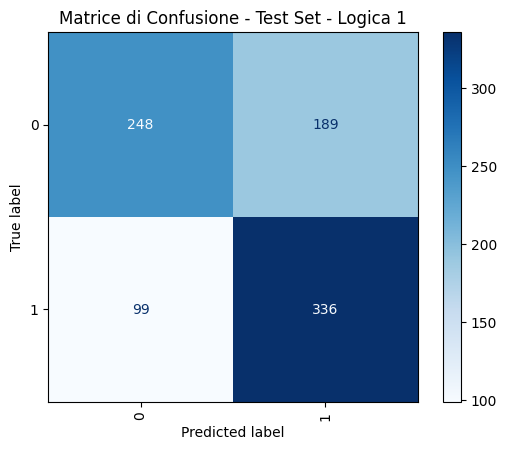

-----------------------------------------------------------------------------------------------------------------------------------
Logica 2 di estrazione delle features: 

 Fold  1 3181 , 796
 Fold  2 3181 , 796
 Fold  3 3182 , 795
 Fold  4 3182 , 795
 Fold  5 3182 , 795


Accuracy su fold 1: 0.6319095477386935
Accuracy su fold 2: 0.6934673366834171
Accuracy su fold 3: 0.6440251572327044
Accuracy su fold 4: 0.6591194968553459
Accuracy su fold 5: 0.680503144654088
 
 Valutazione sul training set: 

              precision    recall  f1-score   support

           0       0.66      0.65      0.66      1954
           1       0.67      0.67      0.67      2023

    accuracy                           0.66      3977
   macro avg       0.66      0.66      0.66      3977
weighted avg       0.66      0.66      0.66      3977
 

 
 Valutazione sul test set: 

              precision    recall  f1-score   support

           0       0.63      0.50      0.56       437
           1       0.58    

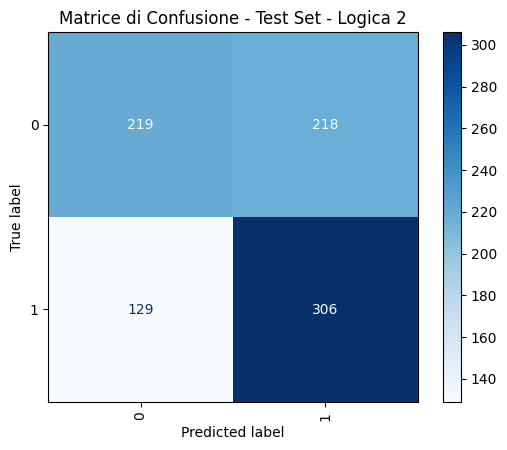

-----------------------------------------------------------------------------------------------------------------------------------
Logica 3 di estrazione delle features: 

 Fold  1 3181 , 796
 Fold  2 3181 , 796
 Fold  3 3182 , 795
 Fold  4 3182 , 795
 Fold  5 3182 , 795


Accuracy su fold 1: 0.6118090452261307
Accuracy su fold 2: 0.6532663316582915
Accuracy su fold 3: 0.6540880503144654
Accuracy su fold 4: 0.6264150943396226
Accuracy su fold 5: 0.670440251572327
 
 Valutazione sul training set: 

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1954
           1       0.65      0.64      0.65      2023

    accuracy                           0.64      3977
   macro avg       0.64      0.64      0.64      3977
weighted avg       0.64      0.64      0.64      3977
 

 
 Valutazione sul test set: 

              precision    recall  f1-score   support

           0       0.63      0.55      0.59       437
           1       0.60    

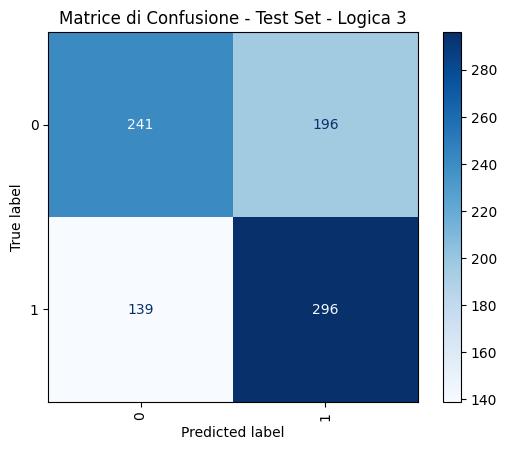

-----------------------------------------------------------------------------------------------------------------------------------


In [71]:
# Realizzo cross-validation utilizzando le features estratte tramite l'utilizzo delle tre diverse logiche
perform_kfold_cross_validation(train_features_1, test_features_1, y_train, y_test, 1)
perform_kfold_cross_validation(train_features_2, test_features_2, y_train, y_test, 2)
perform_kfold_cross_validation(train_features_3, test_features_3, y_train, y_test, 3)